
# Forced Alignment with Wav2Vec2

**Author**: [Moto Hira](moto@meta.com)_

This tutorial shows how to align transcript to speech with
``torchaudio``, using CTC segmentation algorithm described in
[CTC-Segmentation of Large Corpora for German End-to-end Speech
Recognition](https://arxiv.org/abs/2007.09127)_.

<div class="alert alert-info"><h4>Note</h4><p>The implementation in this tutorial is simplified for
   educational purpose.

   If you are looking to align your corpus, we recommend to use
   :py:func:`torchaudio.functional.forced_align`, which is more
   accurate and faster.

   Please refer to [this tutorial](./ctc_forced_alignment_api_tutorial.html)_
   for the detail of :py:func:`~torchaudio.functional.forced_align`.</p></div>


In [9]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

2.0.1+cu117
2.0.2+cu117
cuda


## Overview

The process of alignment looks like the following.

1. Estimate the frame-wise label probability from audio waveform
2. Generate the trellis matrix which represents the probability of
   labels aligned at time step.
3. Find the most likely path from the trellis matrix.

In this example, we use ``torchaudio``\ ’s ``Wav2Vec2`` model for
acoustic feature extraction.




## Preparation

First we import the necessary packages, and fetch data that we work on.




In [10]:
from dataclasses import dataclass
import torch
import torchaudio
import IPython
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm
import re

torch.random.manual_seed(0)

# SPEECH_FILE = torchaudio.utils.download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
SPEECH_FILES = []
TRANSCRIPTS = []

dataset_path_base = '../dataset/fluent_speech_commands_dataset/'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_df = pd.read_csv(os.path.join(dataset_path_base+'/data','train_data.csv'))

for i in tqdm(range(1,5)):
    audio_file = os.path.join(dataset_path_base,train_df.loc[i,'path'])
    SPEECH_FILES.append(audio_file)
    TRANSCRIPTS.append(train_df.loc[i,'transcription'])


100%|██████████| 4/4 [00:00<00:00, 8439.24it/s]


## Generate frame-wise label probability

The first step is to generate the label class porbability of each audio
frame. We can use a Wav2Vec2 model that is trained for ASR. Here we use
:py:func:`torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H`.

``torchaudio`` provides easy access to pretrained models with associated
labels.

<div class="alert alert-info"><h4>Note</h4><p>In the subsequent sections, we will compute the probability in
   log-domain to avoid numerical instability. For this purpose, we
   normalize the ``emission`` with :py:func:`torch.log_softmax`.</p></div>




In [11]:
idx = 0
SPEECH_FILE = SPEECH_FILES[idx]

bundle = torchaudio.pipelines.WAV2VEC2_ASR_LARGE_960H
model = bundle.get_model().to(device)
labels = bundle.get_labels()
print(model)
def hook_fn(module, input, output):
    global layer_output
    layer_output = output
    
layer = model.encoder.transformer.layers[23].final_layer_norm
hook_handle = layer.register_forward_hook(hook_fn)

with torch.inference_mode():
    waveform, _ = torchaudio.load(SPEECH_FILE)
    emissions, _ = model(waveform.to(device))
    # emissions = torch.log_softmax(emissions, dim=-1)

# emission = emissions[0].cpu().detach()
hook_handle.remove()

emissions = layer_output
emissions = torch.log_softmax(emissions, dim=-1)
emissions = emissions[0].detach().cpu()

print(labels)

Wav2Vec2Model(
  (feature_extractor): FeatureExtractor(
    (conv_layers): ModuleList(
      (0): ConvLayerBlock(
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
      )
      (1-4): 4 x ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      )
      (5-6): 2 x ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
      )
    )
  )
  (encoder): Encoder(
    (feature_projection): FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=1024, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (pos_conv_embed): ConvolutionalPositionalEmbedding(
        (conv): Conv1d(1024, 1024, kernel_size=(128,), stride=(1,), padding=(64,), groups=16)
      )
      (layer_norm): LayerNorm((10

In [12]:
emissions.shape

torch.Size([69, 1024])

### Visualization



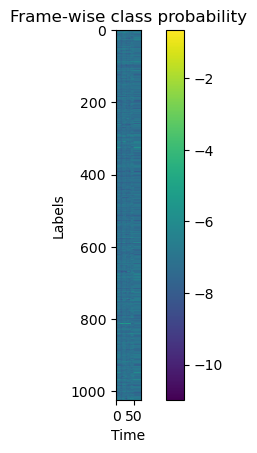

In [13]:
def plot(emissions):
    plt.imshow(emissions.T)
    plt.colorbar()
    plt.title("Frame-wise class probability")
    plt.xlabel("Time")
    plt.ylabel("Labels")


plot(emissions)

## Generate alignment probability (trellis)

From the emission matrix, next we generate the trellis which represents
the probability of transcript labels occur at each time frame.

Trellis is 2D matrix with time axis and label axis. The label axis
represents the transcript that we are aligning. In the following, we use
$t$ to denote the index in time axis and $j$ to denote the
index in label axis. $c_j$ represents the label at label index
$j$.

To generate, the probability of time step $t+1$, we look at the
trellis from time step $t$ and emission at time step $t+1$.
There are two path to reach to time step $t+1$ with label
$c_{j+1}$. The first one is the case where the label was
$c_{j+1}$ at $t$ and there was no label change from
$t$ to $t+1$. The other case is where the label was
$c_j$ at $t$ and it transitioned to the next label
$c_{j+1}$ at $t+1$.

The follwoing diagram illustrates this transition.

<img src="https://download.pytorch.org/torchaudio/tutorial-assets/ctc-forward.png">

Since we are looking for the most likely transitions, we take the more
likely path for the value of $k_{(t+1, j+1)}$, that is

$k_{(t+1, j+1)} = max( k_{(t, j)} p(t+1, c_{j+1}), k_{(t, j+1)} p(t+1, repeat) )$

where $k$ represents is trellis matrix, and $p(t, c_j)$
represents the probability of label $c_j$ at time step $t$.
$repeat$ represents the blank token from CTC formulation. (For the
detail of CTC algorithm, please refer to the *Sequence Modeling with CTC*
[[distill.pub](https://distill.pub/2017/ctc/)_])




In [14]:
# We enclose the transcript with space tokens, which represent SOS and EOS.
transcript = TRANSCRIPTS[idx].upper()
transcript = re.sub("\s", "|",transcript)
dictionary = {c: i for i, c in enumerate(labels)}

tokens = [dictionary[c] for c in transcript]
print(list(zip(transcript, tokens)))


def get_trellis(emission, tokens, blank_id=0):
    num_frame = emission.size(0)
    num_tokens = len(tokens)

    trellis = torch.zeros((num_frame, num_tokens))
    trellis[1:, 0] = torch.cumsum(emission[1:, blank_id], 0)
    trellis[0, 1:] = -float("inf")
    trellis[-num_tokens + 1 :, 0] = float("inf")

    for t in range(num_frame - 1):
        trellis[t + 1, 1:] = torch.maximum(
            # Score for staying at the same token
            trellis[t, 1:] + emission[t, blank_id],
            # Score for changing to the next token
            trellis[t, :-1] + emission[t, tokens[1:]],
        )
    return trellis


trellis = get_trellis(emissions, tokens)
print(trellis.shape)

[('R', 10), ('E', 2), ('S', 9), ('U', 13), ('M', 14), ('E', 2)]
torch.Size([69, 6])


### Visualization



In [15]:
# def plot():
#     plt.imshow(trellis.T, origin="lower")
#     plt.annotate("- Inf", (trellis.size(1) / 5, trellis.size(1) / 1.5))
#     plt.annotate("+ Inf", (trellis.size(0) - trellis.size(1) / 5, trellis.size(1) / 3))
#     plt.colorbar()


# plot()

In the above visualization, we can see that there is a trace of high
probability crossing the matrix diagonally.




## Find the most likely path (backtracking)

Once the trellis is generated, we will traverse it following the
elements with high probability.

We will start from the last label index with the time step of highest
probability, then, we traverse back in time, picking stay
($c_j \rightarrow c_j$) or transition
($c_j \rightarrow c_{j+1}$), based on the post-transition
probability $k_{t, j} p(t+1, c_{j+1})$ or
$k_{t, j+1} p(t+1, repeat)$.

Transition is done once the label reaches the beginning.

The trellis matrix is used for path-finding, but for the final
probability of each segment, we take the frame-wise probability from
emission matrix.




In [16]:
@dataclass
class Point:
    token_index: int
    time_index: int
    score: float


def backtrack(trellis, emission, tokens, blank_id=0):
    t, j = trellis.size(0) - 1, trellis.size(1) - 1

    path = [Point(j, t, emission[t, blank_id].exp().item())]
    while j > 0:
        # Should not happen but just in case
        assert t > 0

        # 1. Figure out if the current position was stay or change
        # Frame-wise score of stay vs change
        p_stay = emission[t - 1, blank_id]
        p_change = emission[t - 1, tokens[j]]

        # Context-aware score for stay vs change
        stayed = trellis[t - 1, j] + p_stay
        changed = trellis[t - 1, j - 1] + p_change

        # Update position
        t -= 1
        if changed > stayed:
            j -= 1

        # Store the path with frame-wise probability.
        prob = (p_change if changed > stayed else p_stay).exp().item()
        path.append(Point(j, t, prob))

    # Now j == 0, which means, it reached the SoS.
    # Fill up the rest for the sake of visualization
    while t > 0:
        prob = emission[t - 1, blank_id].exp().item()
        path.append(Point(j, t - 1, prob))
        t -= 1

    return path[::-1]


path = backtrack(trellis, emission, tokens)
for p in path:
    print(p)

NameError: name 'emission' is not defined

### Visualization



In [ ]:
# def plot_trellis_with_path(trellis, path):
#     # To plot trellis with path, we take advantage of 'nan' value
#     trellis_with_path = trellis.clone()
#     for _, p in enumerate(path):
#         trellis_with_path[p.time_index, p.token_index] = float("nan")
#     plt.imshow(trellis_with_path.T, origin="lower")


# plot_trellis_with_path(trellis, path)
# plt.title("The path found by backtracking")

Looking good.



## Segment the path
Now this path contains repetations for the same labels, so
let’s merge them to make it close to the original transcript.

When merging the multiple path points, we simply take the average
probability for the merged segments.




In [ ]:
# Merge the labels
@dataclass
class Segment:
    label: str
    start: int
    end: int
    score: float

    def __repr__(self):
        return f"{self.label} ({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

    @property
    def length(self):
        return self.end - self.start


def merge_repeats(path):
    i1, i2 = 0, 0
    segments = []
    while i1 < len(path):
        while i2 < len(path) and path[i1].token_index == path[i2].token_index:
            i2 += 1
        score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
        segments.append(
            Segment(
                transcript[path[i1].token_index],
                path[i1].time_index,
                path[i2 - 1].time_index + 1,
                score,
            )
        )
        i1 = i2
    return segments


segments = merge_repeats(path)
for seg in segments:
    print(seg)

T (1.04): [    0,    22)
U (1.06): [   22,    39)
R (1.13): [   39,    42)
N (0.96): [   42,    47)
| (0.92): [   47,    48)
T (1.15): [   48,    50)
H (1.17): [   50,    53)
E (1.35): [   53,    56)
| (1.20): [   56,    63)
L (0.99): [   63,    64)
I (1.08): [   64,    65)
G (1.25): [   65,    66)
H (0.93): [   66,    77)
T (1.13): [   77,    78)
S (0.96): [   78,    87)
| (0.90): [   87,    88)
O (1.06): [   88,    89)
N (1.01): [   89,   106)


### Visualization



In [ ]:
# def plot_trellis_with_segments(trellis, segments, transcript):
#     # To plot trellis with path, we take advantage of 'nan' value
#     trellis_with_path = trellis.clone()
#     for i, seg in enumerate(segments):
#         if seg.label != "|":
#             trellis_with_path[seg.start : seg.end, i] = float("nan")

#     fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
#     ax1.set_title("Path, label and probability for each label")
#     ax1.imshow(trellis_with_path.T, origin="lower", aspect="auto")

#     for i, seg in enumerate(segments):
#         if seg.label != "|":
#             ax1.annotate(seg.label, (seg.start, i - 0.7), size="small")
#             ax1.annotate(f"{seg.score:.2f}", (seg.start, i + 3), size="small")

#     ax2.set_title("Label probability with and without repetation")
#     xs, hs, ws = [], [], []
#     for seg in segments:
#         if seg.label != "|":
#             xs.append((seg.end + seg.start) / 2 + 0.4)
#             hs.append(seg.score)
#             ws.append(seg.end - seg.start)
#             ax2.annotate(seg.label, (seg.start + 0.8, -0.07))
#     ax2.bar(xs, hs, width=ws, color="gray", alpha=0.5, edgecolor="black")

#     xs, hs = [], []
#     for p in path:
#         label = transcript[p.token_index]
#         if label != "|":
#             xs.append(p.time_index + 1)
#             hs.append(p.score)

#     ax2.bar(xs, hs, width=0.5, alpha=0.5)
#     ax2.axhline(0, color="black")
#     ax2.grid(True, axis="y")
#     ax2.set_ylim(-0.1, 1.1)
#     fig.tight_layout()


# plot_trellis_with_segments(trellis, segments, transcript)

Looks good.



## Merge the segments into words
Now let’s merge the words. The Wav2Vec2 model uses ``'|'``
as the word boundary, so we merge the segments before each occurance of
``'|'``.

Then, finally, we segment the original audio into segmented audio and
listen to them to see if the segmentation is correct.




In [ ]:
# Merge words
def merge_words(segments, separator="|"):
    words = []
    i1, i2 = 0, 0
    while i1 < len(segments):
        if i2 >= len(segments) or segments[i2].label == separator:
            if i1 != i2:
                segs = segments[i1:i2]
                word = "".join([seg.label for seg in segs])
                score = sum(seg.score * seg.length for seg in segs) / sum(seg.length for seg in segs)
                words.append(Segment(word, segments[i1].start, segments[i2 - 1].end, score))
            i1 = i2 + 1
            i2 = i1
        else:
            i2 += 1
    return words


word_segments = merge_words(segments)
for word in word_segments:
    print(word)

TURN (1.04): [    0,    47)
THE (1.23): [   48,    56)
LIGHTS (0.97): [   63,    87)
ON (1.02): [   88,   106)


### Visualization



In [ ]:
# def plot_alignments(trellis, segments, word_segments, waveform):
#     trellis_with_path = trellis.clone()
#     for i, seg in enumerate(segments):
#         if seg.label != "|":
#             trellis_with_path[seg.start : seg.end, i] = float("nan")

#     fig, [ax1, ax2] = plt.subplots(2, 1)

#     ax1.imshow(trellis_with_path.T, origin="lower", aspect="auto")
#     ax1.set_xticks([])
#     ax1.set_yticks([])

#     for word in word_segments:
#         ax1.axvline(word.start - 0.5)
#         ax1.axvline(word.end - 0.5)

#     for i, seg in enumerate(segments):
#         if seg.label != "|":
#             ax1.annotate(seg.label, (seg.start, i - 0.7), size="small")
#             ax1.annotate(f"{seg.score:.2f}", (seg.start, i + 3), size="small")

#     # The original waveform
#     ratio = waveform.size(0) / trellis.size(0)
#     ax2.plot(waveform)
#     for word in word_segments:
#         x0 = ratio * word.start
#         x1 = ratio * word.end
#         ax2.axvspan(x0, x1, alpha=0.1, color="red")
#         ax2.annotate(f"{word.score:.2f}", (x0, 0.8))

#     for seg in segments:
#         if seg.label != "|":
#             ax2.annotate(seg.label, (seg.start * ratio, 0.9))
#     xticks = ax2.get_xticks()
#     plt.xticks(xticks, xticks / bundle.sample_rate)
#     ax2.set_xlabel("time [second]")
#     ax2.set_yticks([])
#     ax2.set_ylim(-1.0, 1.0)
#     ax2.set_xlim(0, waveform.size(-1))
#     fig.tight_layout()


# plot_alignments(
#     trellis,
#     segments,
#     word_segments,
#     waveform[0],
# )

## Audio Samples




In [ ]:
waveform.shape

torch.Size([1, 34180])

In [ ]:
# A trick to embed the resulting audio to the generated file.
# `IPython.display.Audio` has to be the last call in a cell,
# and there should be only one call par cell.
def display_segment(i):
    ratio = waveform.size(1) / trellis.size(0)
    word = word_segments[i]
    x0 = int(ratio * word.start)
    x1 = int(ratio * word.end)
    print(f"{word.label} ({word.score:.2f}): {x0 / bundle.sample_rate:.3f} - {x1 / bundle.sample_rate:.3f} sec")
    segment = waveform[0, x0:x1]
    return IPython.display.Audio(segment.numpy(), rate=bundle.sample_rate)

In [ ]:
# Generate the audio for each segment
print(transcript)
IPython.display.Audio(SPEECH_FILE)

TURN|THE|LIGHTS|ON


In [ ]:
len(word_segments)

4

In [ ]:
display_segment(0)

TURN (1.04): 0.000 - 0.947 sec


In [ ]:
display_segment(1)

THE (1.23): 0.967 - 1.129 sec


In [ ]:
display_segment(2)

LIGHTS (0.97): 1.270 - 1.753 sec


In [ ]:
display_segment(3)

ON (1.02): 1.773 - 2.136 sec


## Conclusion

In this tutorial, we looked how to use torchaudio’s Wav2Vec2 model to
perform CTC segmentation for forced alignment.


